<a href="https://colab.research.google.com/github/NilsLevillain/Rentalytics/blob/main/Rentalytics_perso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Packages

In [ ]:
pip install logzero

In [ ]:
import pandas as pd
import requests
import os
import time
import itertools
from datetime import datetime
from bs4 import BeautifulSoup
from tqdm import tqdm, trange
from logzero import logger
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium.plugins import HeatMap
import plotly.express as px
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

#Functions definition

In [ ]:
def authenticate(email, password):
    auth_url = 'https://api.jinka.fr/apiv2/user/auth'
    auth_dict = {'email':email, 'password':password}
    s = requests.Session()
    r_auth = s.post(auth_url, auth_dict)
    if r_auth.status_code == 200:
        logger.info('Authentification succeeded (200)')
        access_token = r_auth.json()['access_token']
    else:
        logger.critical(f'Authentification failed with error {r_auth.status_code}')
        return None, None

    headers = {
    'Accept': '*/*',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36',
    'Accept-Language': 'fr,fr-FR;q=0.8,en-US;q=0.5,en;q=0.3',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {access_token}',
    'Origin': 'https://www.jinka.fr',
    'Connection': 'keep-alive',
    'DNT': '1',
    'Sec-GPC': '1',
    'If-None-Match': 'W/f46-qWZd5Nq9sjWAv9cj3oEhFaxFuek',
    'TE': 'Trailers',
    }

    return s, headers

def get_alerts(session, headers):
    r_alerts = session.get('https://api.jinka.fr/apiv2/alert', headers=headers)
    df_alerts = pd.DataFrame(columns=['id', 'name', 'user_name', 'ads_per_day'])
    data_dict = {'id':[], 'name':[], 'user_name':[], 'ads_per_day':[], 'nb_pages':[], 'all':[], 'read':[],
    'unread':[], 'favorite':[], 'deleted':[]}
    for counter, alert in enumerate(r_alerts.json()):

        data_dict['id'].append(alert['id'])
        data_dict['name'].append(alert['name'])
        data_dict['user_name'].append(alert['user_name'])
        data_dict['ads_per_day'].append(alert['estimated_ads_per_day'])

        root_url = 'https://api.jinka.fr/apiv2/alert/' + str(alert['id']) + '/dashboard'

        r_pagination = session.get(root_url, headers=headers)
        pagination_data = r_pagination.json()['pagination']
        data_dict['nb_pages'].append(pagination_data['nbPages'])
        data_dict['all'].append(pagination_data['totals']['all'])
        data_dict['read'].append(pagination_data['totals']['read'])
        data_dict['unread'].append(pagination_data['totals']['unread'])
        data_dict['favorite'].append(pagination_data['totals']['favorite'])
        #data_dict['contact'].append(pagination_data['totals']['contact'])
        data_dict['deleted'].append(pagination_data['totals']['deleted'])

        logger.info(f'{counter+1} / {len(r_alerts.json())} alerts have been processed.')

    df_alerts = pd.DataFrame(data=data_dict)
    return df_alerts

def get_apparts(session, headers, alert_id, nb_pages):
    root_url = 'https://api.jinka.fr/apiv2/alert/' + str(alert_id) + '/dashboard'
    df_apparts = pd.DataFrame(columns= ['id', 'source', 'source_is_partner', 'source_logo', 'source_label', 'search_type', 'owner_type', \
        'rent', 'rent_max', 'area', 'room', 'bedroom', 'floor', 'type', 'buy_type', 'city', 'postal_code', 'lat', 'lng',  'furnished', \
        'description', 'description_is_truncated', 'images', 'created_at', 'expired_at', 'sendDate', 'previous_rent',  'previous_rent_at', \
        'favorite', 'nb_spam', 'contacted', 'stops', 'features', 'new_real_estate', 'rentMinPerM2', 'clicked_at', 'webview_link', 'alert_id', \
        'page'])
    for page in trange(1, nb_pages+1):
        target_url = root_url + f'?filter=all&page={page}'
        r_apparts = session.get(target_url, headers=headers)
        df_temp = pd.DataFrame.from_records(data=r_apparts.json()['ads'])
        df_temp['page'] = page
        #df_apparts = df_apparts.append(df_temp)
        df_apparts = pd.concat([df_apparts, df_temp], ignore_index = True)
    return df_apparts

def get_all_apparts(df_alerts, session, headers):
    df_final = pd.DataFrame(columns= ['id', 'source', 'source_is_partner', 'source_logo', 'source_label',
     'search_type', 'owner_type', 'rent', 'rent_max', 'area', 'room', 'bedroom', 'floor', 'type', 'buy_type',
      'city', 'postal_code', 'lat', 'lng',  'furnished', 'description', 'description_is_truncated', 'images',
       'created_at', 'expired_at', 'sendDate', 'previous_rent',  'previous_rent_at', 'favorite', 'nb_spam', 'contacted',
        'stops', 'features', 'new_real_estate', 'rentMinPerM2', 'clicked_at', 'webview_link', 'alert_id'])
    for idx, alert in df_alerts.iterrows():
        logger.info(f'Starting the processing of the apparts of alert n°{idx + 1}')
        alert_id = alert['id']
        nb_pages = alert['nb_pages']
        df_alert = get_apparts(session, headers, alert_id, nb_pages)
        #df_final = df_final.append(df_alert)
        df_final = pd.concat([df_final, df_alert], ignore_index = True)
        logger.info(f'Finished processing the apparts of alert n°{idx + 1}')
    df_final = df_final.set_index('id')
    expired_index = df_final[df_final['expired_at'].notna()].index
    logger.warning(f"{len(expired_index)} apparts have expired.")
    return df_final, expired_index

##Functions instanciation

In [ ]:
pd.set_option('display.max_columns', None)

s, headers = authenticate("levillain.nils@gmail.com", "TestMDP12!")

df_alerts = get_alerts(s, headers)
df_alerts

df_appart_buy = get_apparts(s, headers, df_alerts['id'][0], df_alerts['nb_pages'][0])

df_get_all_apparts = get_all_apparts(df_alerts, s, headers)

[I 240612 15:56:43 <ipython-input-130-34fcfce4c1ca>:7] Authentification succeeded (200)
[I 240612 15:56:44 <ipython-input-130-34fcfce4c1ca>:53] 1 / 1 alerts have been processed.
100%|██████████| 7/7 [00:02<00:00,  2.58it/s]
[I 240612 15:56:47 <ipython-input-130-34fcfce4c1ca>:81] Starting the processing of the apparts of alert n°1
100%|██████████| 7/7 [00:02<00:00,  2.41it/s]
[I 240612 15:56:50 <ipython-input-130-34fcfce4c1ca>:87] Finished processing the apparts of alert n°1
[W 240612 15:56:50 <ipython-input-130-34fcfce4c1ca>:90] 0 apparts have expired.


#Feature engineering & cleaning

### Definition

In [ ]:
def metro_extractor(metro_ls):
    stops_names = [x['name'] for x in metro_ls]
    lines_names = [x['lines'] for x in metro_ls]
    lines_names = set(itertools.chain.from_iterable(lines_names))
    return [stops_names, lines_names]

def cleaner(df, columns=['source_logo', 'source_label', 'search_type',
 'rent_max', 'bedroom', 'buy_type', 'new_real_estate', 'webview_link', 'source_description']):

    df['features'] = df['features'].apply(lambda x: {} if pd.isna(x) else x)
    df_extract = pd.json_normalize(df['features'])
    df = df.merge(df_extract, how='left', on='id')

    metro_res = df['stops'].apply(lambda x: metro_extractor(x))
    df[['metro_stations', 'metro_lines']] = pd.DataFrame(metro_res.tolist(), index=df.index)

    columns_to_drop = columns + ['year', 'box', 'stops', 'features']
    df = df.drop(columns=columns_to_drop)
    return df

def features_engineering(df):
    df['price_m2'] = df['rent'] / df['area']
    df['rent_evolution'] = df['previous_rent'] - df['rent']
    df['geo_coords'] = df['lat'].astype('string') + ', ' + df['lng'].astype('string')
    df = df.drop(columns=['previous_rent'])#, 'lat', 'lng'])
    return df


###Execution

In [ ]:
df.columns.tolist()

['id',
 'source',
 'source_is_partner',
 'owner_type',
 'purchase_price',
 'area',
 'room',
 'floor',
 'type',
 'city',
 'postal_code',
 'lat',
 'lng',
 'furnished',
 'description',
 'description_is_truncated',
 'images',
 'created_at',
 'expired_at',
 'sendDate',
 'previous_rent_at',
 'favorite',
 'nb_spam',
 'contacted',
 'rentMinPerM2',
 'clicked_at',
 'alert_id',
 'page',
 'uuid',
 'energy_dpe',
 'energy_ges',
 'favorite_id',
 'quartier',
 'is_coliving',
 'should_reduce_info',
 'source_is_subscribed',
 'source_is_plato_supported',
 'source_logo_fallback',
 'quartier_name',
 'spam_content_warning',
 'reported_error',
 'land_area',
 'coduminium_lots',
 'coduminium_charges',
 'coduminium_pending_prejudice',
 'high_demand',
 'lift',
 'shower',
 'bath',
 'parking',
 'balcony',
 'terracy',
 'cave',
 'garden',
 'metro_stations',
 'metro_lines',
 'price_m2',
 'rent_evolution',
 'geo_coords',
 'flat_type']

In [ ]:
# Using boolean indexing for filtering
df_filtered = df[(df['room'] == 1) | (df['room'] == 2)][['room', 'energy_dpe', 'area',]]
df_filtered.sort_values(by=['room', 'energy_dpe', 'area'], ascending=[True, True, True])

,room,energy_dpe,area
120,1,A,32
79,1,D,43
137,1,E,70
81,2,C,36
75,2,D,34
62,2,D,37
33,2,D,40
142,2,D,41
77,2,D,43
141,2,D,43


In [ ]:
df_get_apparts_clean = cleaner(df_appart_buy)
df_get_apparts_clean_new_features = features_engineering(df_get_apparts_clean)
df = df_get_apparts_clean_new_features

df['rent'] = pd.to_numeric(df['rent'], errors='coerce')
df['area'] = pd.to_numeric(df['area'], errors='coerce')
df['room'] = pd.to_numeric(df['room'], errors='coerce')
df['previous_rent_at'] = pd.to_numeric(df['previous_rent_at'], errors='coerce')
df['rent_evolution'] = pd.to_numeric(df['rent_evolution'], errors='coerce')
df['price_m2'] = pd.to_numeric(df['price_m2'], errors='coerce')

# Rename 'rent' column to 'purchase_price'
df.rename(columns={'rent': 'purchase_price'}, inplace=True)

# Update the rest of your code to use 'purchase_price'
df['flat_type'] = 'T' + df['room'].astype(str)


df_filtered = df[((df['flat_type'] == 'T1') & (df['area'] > 30)) |
                 ((df['flat_type'] == 'T2') & (df['area'] > 30)) |
                 ((df['flat_type'] == 'T3') & (df['area'] > 50))]

# Handle NaN values in 'energy_dpe' and filter 'df_biens'
df_filtered['energy_dpe'] = df_filtered['energy_dpe'].replace(np.nan, 'NaN')
df_biens = df_filtered[df_filtered['energy_dpe'].isin(['F', 'G', 'NaN'])]

#Filter 'df_biens' with the métiers conditions
##surface
df_biens = df_biens[((df_biens['flat_type'] == 'T1') & (df_biens['area'] > 30)) |
                            ((df_biens['flat_type'] == 'T2') & (df_biens['area'] > 50))]
##doublons ?
##energie
#df_biens = df_biens[(df_biens['energy_dpe'] == 'F') |
 #                            (df_biens['energy_dpe'] == 'G') |
  #                            (df_biens['energy_dpe'] == 'NaN')]

# Create a new column 'id_bien' to distinguish between categories
df_biens['id_bien'] = np.where(
    (df_biens['flat_type'] == 'T1') & (df_biens['area'] > 30),
    'grand_t1_achat',
    np.where(
        (df_biens['flat_type'] == 'T2') & (df_biens['area'] > 50),
        'grand_t2_achat',
        np.nan
    )
)



# Filter 'df_prix_vente' with the new conditions
##surface
df_prix_vente = df_filtered[((df_filtered['flat_type'] == 'T2') & (df_filtered['area'] > 30)) |
                            ((df_filtered['flat_type'] == 'T3') & (df_filtered['area'] > 50))]

##energie
df_prix_vente = df_prix_vente[(df_prix_vente['energy_dpe'] == 'D') |
                             (df_prix_vente['energy_dpe'] == 'E') |
                              (df_prix_vente['energy_dpe'] == 'NaN')]

# Create a new column 'id_bien' to distinguish between categories in 'df_prix_vente'
df_prix_vente['id_bien'] = np.where(
    (df_prix_vente['flat_type'] == 'T2') & (df_prix_vente['area'] > 30),
    'grand_t1_vente',
    np.where(
        (df_prix_vente['flat_type'] == 'T3') & (df_prix_vente['area'] > 50),
        'grand_t2_vente',
        np.nan
    )
)



# Calculate the mean purchase price for properties to be sold after renovation
market_price = df_prix_vente['purchase_price'].mean()
print(f"Market price for sale: {market_price.round(0)}€")

market_price_t2 = df_prix_vente[df_prix_vente['id_bien'] == 'grand_t1_vente']['purchase_price'].mean()
market_price_t3 = df_prix_vente[df_prix_vente['id_bien'] == 'grand_t2_vente']['purchase_price'].mean()
print(f"Market price for sale: for a T2 DPE 'D' or 'E'{market_price_t2.round(0)}€")
print(f"Market price for sale: for a T3 DPE 'D' or 'E'{market_price_t3.round(0)}€")

# Cost of renovation: 1000 per m²
df_biens['renovation_price'] = 1000 * df_biens['area']

# Copropriété charges
df_biens['copro_price'] = 2000

#Exposition N/S/E/O ou vue sur cour


# State aid for energy renovation
df_biens['aide_price'] = 5000

# Calculate the real purchase price after adding renovation costs and subtracting state aid
df_biens['real_purchase_price'] = df_biens['purchase_price'] + df_biens['renovation_price'] + df_biens['copro_price'] - df_biens['aide_price']

# Calculate profitability for 'grand_t1_achat'
df_biens['profitability'] = np.where(
    df_biens['id_bien'] == 'grand_t1_achat',
    (market_price_t2 - df_biens['real_purchase_price']) / df_biens['real_purchase_price'],
    np.nan #initializing the profitability column in df_biens
)

# Calculate profitability for 'grand_t2_achat'
df_biens['profitability'] = np.where(
    df_biens['id_bien'] == 'grand_t2_achat',
    (market_price_t3 - df_biens['real_purchase_price']) / df_biens['real_purchase_price'],
    df_biens['profitability']  # Keep the updated profitability values for other rows
)

# Format profitability as a percentage and round to 2 decimal places
df_biens['profitability'] = pd.to_numeric(df_biens['profitability'], errors='coerce').dropna()
df_biens['profitability'] = (df_biens['profitability'] * 100).round(2).astype(str) + '%'

# Sort by profitability in descending order and update the DataFrame
df_biens = df_biens.sort_values(by='profitability', ascending=False)


Market price for sale: 126568.0€
Market price for sale: for a T2 DPE 'D' or 'E'116882.0€
Market price for sale: for a T3 DPE 'D' or 'E'135812.0€


---
#EDA


In [ ]:
#Data stucture
# Display the shape of the dataframe
print(f"Shape of df_appart_buy = {df_appart_buy.shape}")
print(f"Shape of df = {df.shape}")
print(f"Shape of df_filtered = {df_filtered.shape}")
print(f"Shape of df_biens = {df_biens.shape}")
print(f"Shape of df_prix = {df_prix_vente.shape}")

# Get a concise summary of the dataframe
#print("df_appart_buy")
#print(df_appart_buy.info())
#print("df")
#print(df.info())
#print("df_filtered")
#print(df_filtered.info())
#print("df_biens")
#print(df_biens.info())
#print("df_prix_vente")
#print(df_prix_vente.info())


Shape of df_appart_buy = (164, 58)
Shape of df = (164, 60)
Shape of df_filtered = (57, 60)
Shape of df_biens = (1, 66)
Shape of df_prix = (43, 61)


df_filtered
df_filtered
df_filtered
df_filtered
df_filtered
       purchase_price        area       room      floor        lat        lng  \
count       57.000000   57.000000  57.000000  44.000000  21.000000  21.000000   
mean    133477.456140   62.175439   2.508772   0.909091  46.324771  -0.460375   
std      38798.929283   20.430302   0.601273   1.789091   0.005762   0.011442   
min      66900.000000   32.000000   1.000000  -1.000000  46.317900  -0.483797   
25%     103000.000000   48.000000   2.000000   0.000000  46.321200  -0.463380   
50%     127800.000000   63.000000   3.000000   0.000000  46.322300  -0.463380   
75%     158000.000000   70.000000   3.000000   1.000000  46.328500  -0.455104   
max     239900.000000  146.000000   3.000000   7.000000  46.342600  -0.436231   

       previous_rent_at  is_coliving    land_area  coduminium_lots  \
count               0.0         57.0    13.000000              2.0   
mean                NaN          0.0   298.615385              2.0   


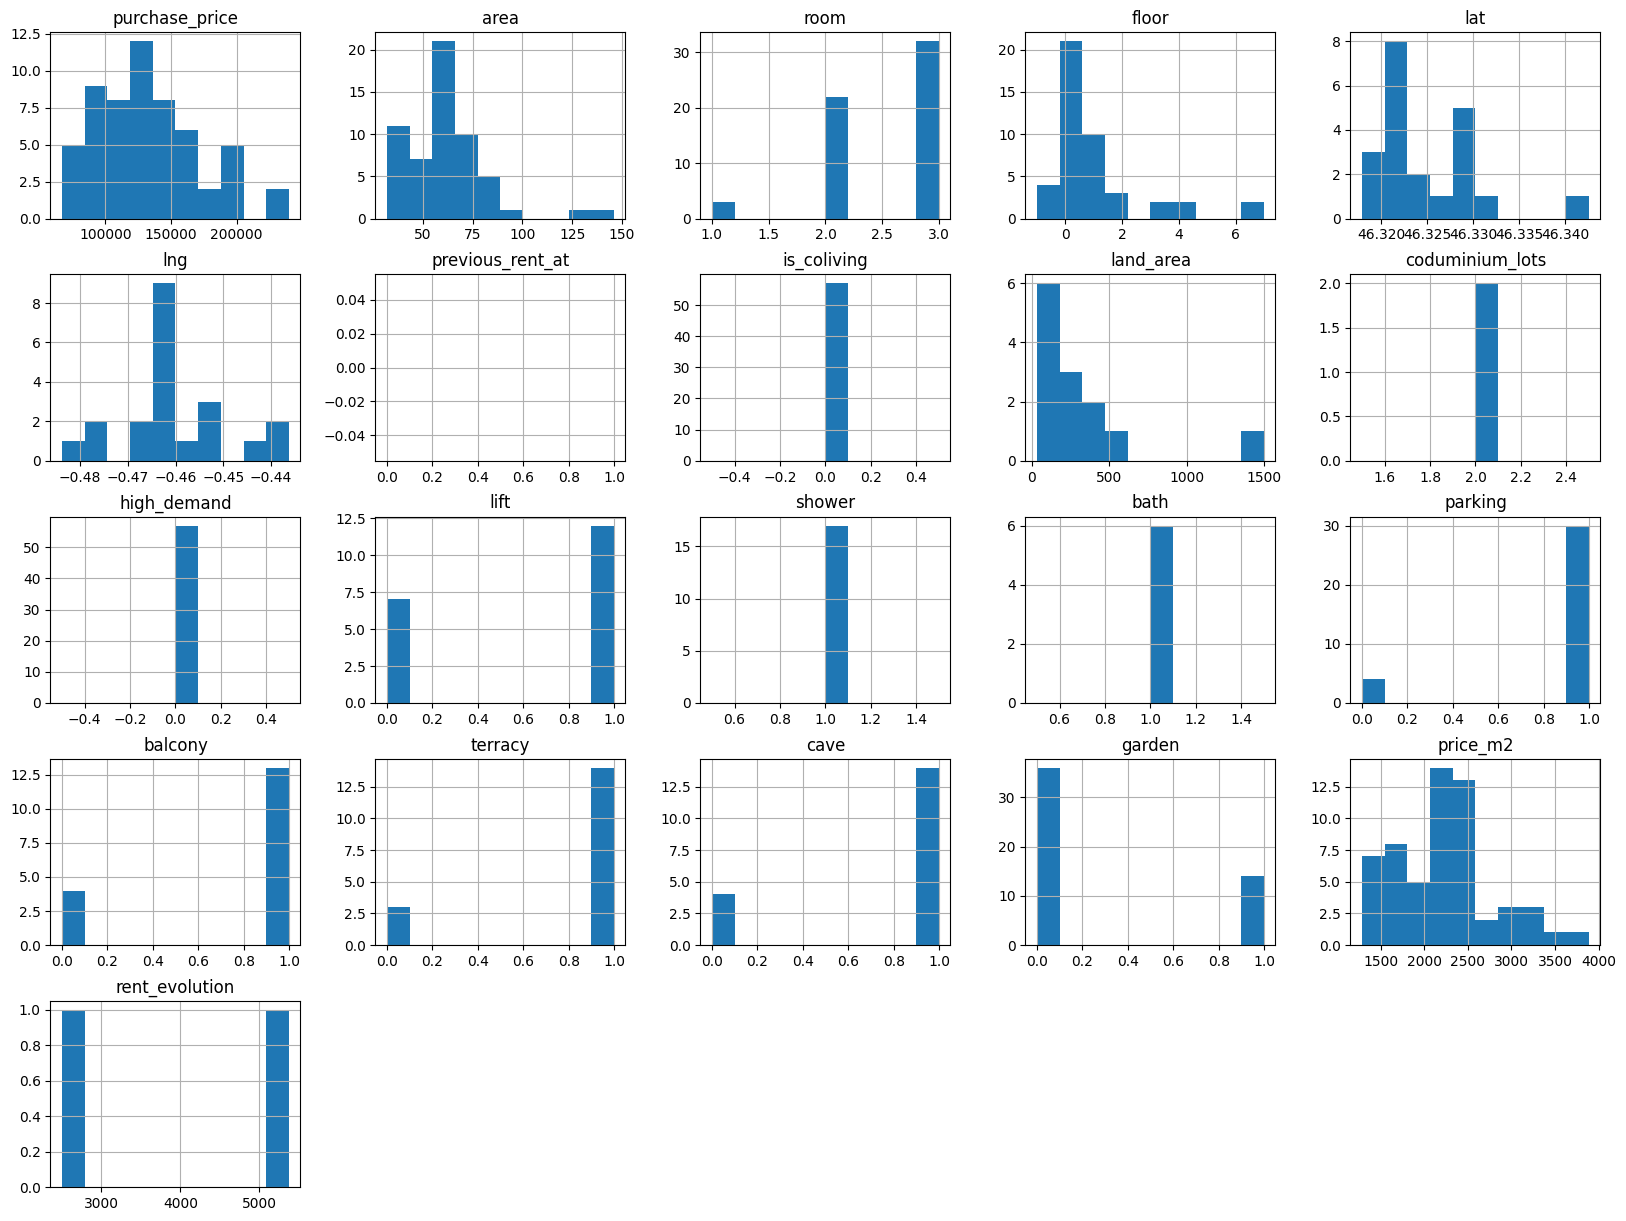

df_biens
df_biens
df_biens
df_biens
df_biens
       purchase_price   area  room  floor  lat  lng  previous_rent_at  \
count             1.0    1.0   1.0    1.0  0.0  0.0               0.0   
mean         195120.0  126.0   2.0    0.0  NaN  NaN               NaN   
std               NaN    NaN   NaN    NaN  NaN  NaN               NaN   
min          195120.0  126.0   2.0    0.0  NaN  NaN               NaN   
25%          195120.0  126.0   2.0    0.0  NaN  NaN               NaN   
50%          195120.0  126.0   2.0    0.0  NaN  NaN               NaN   
75%          195120.0  126.0   2.0    0.0  NaN  NaN               NaN   
max          195120.0  126.0   2.0    0.0  NaN  NaN               NaN   

       is_coliving  land_area  coduminium_lots  high_demand  lift  shower  \
count          1.0        0.0              0.0          1.0   0.0     0.0   
mean           0.0        NaN              NaN          0.0   NaN     NaN   
std            NaN        NaN              NaN          NaN   NaN 

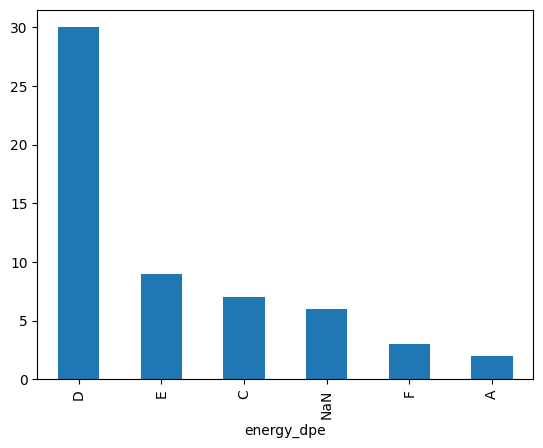

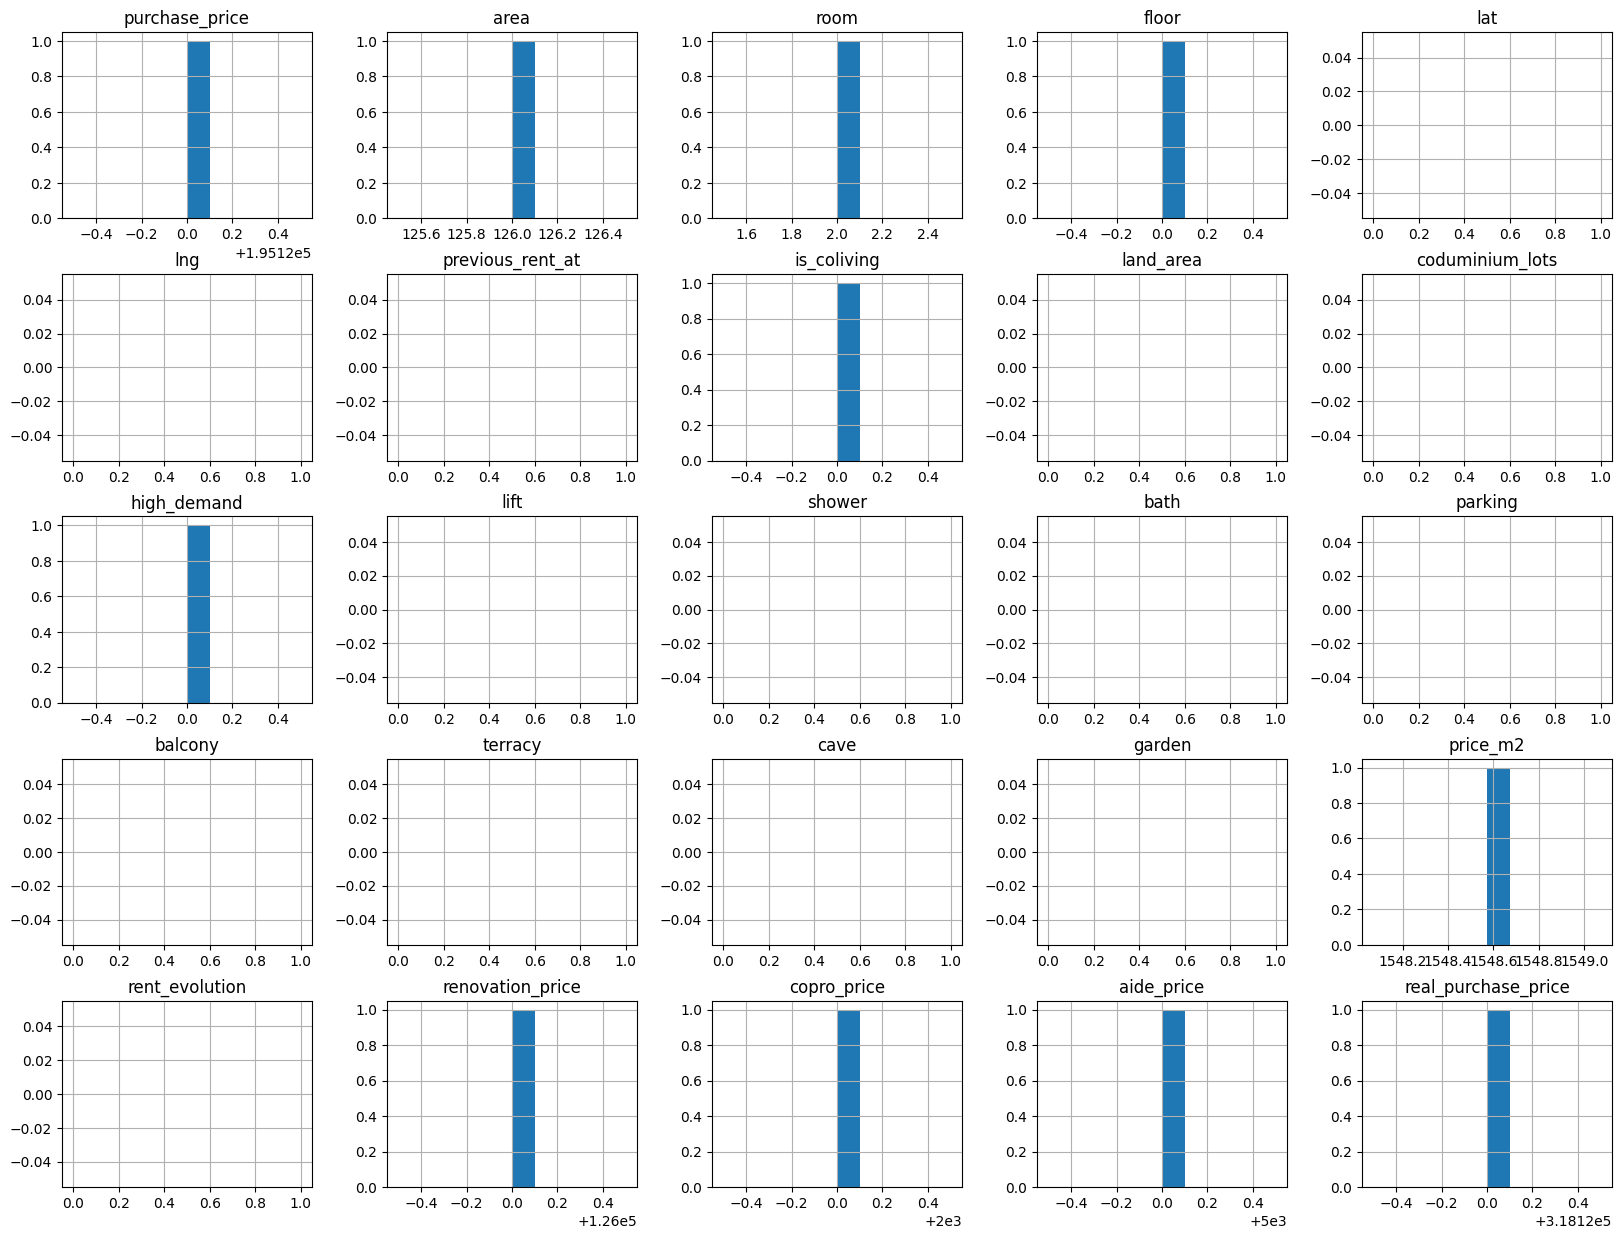

df_prix_vente
df_prix_vente
df_prix_vente
df_prix_vente
df_prix_vente
       purchase_price        area       room      floor        lat        lng  \
count       43.000000   43.000000  43.000000  34.000000  15.000000  15.000000   
mean    126567.558140   60.558140   2.511628   0.941176  46.325253  -0.461054   
std      32654.247506   17.767416   0.505781   1.937527   0.006511   0.012905   
min      82390.000000   33.000000   2.000000  -1.000000  46.317900  -0.483797   
25%     100000.000000   47.000000   2.000000   0.000000  46.321200  -0.466384   
50%     119900.000000   61.000000   3.000000   0.000000  46.323200  -0.463380   
75%     146250.000000   65.000000   3.000000   1.000000  46.329050  -0.454014   
max     199900.000000  126.000000   3.000000   7.000000  46.342600  -0.436231   

       previous_rent_at  is_coliving    land_area  coduminium_lots  \
count               0.0         43.0     8.000000              1.0   
mean                NaN          0.0   317.875000           

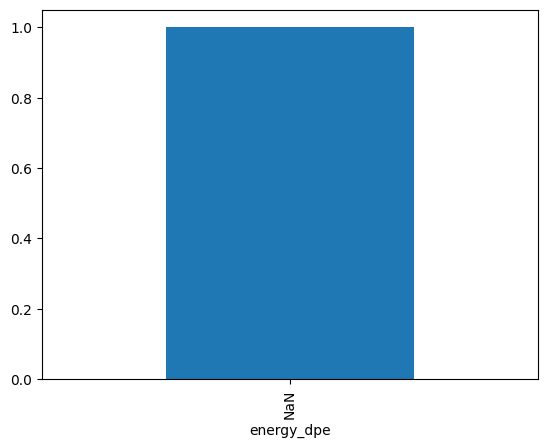

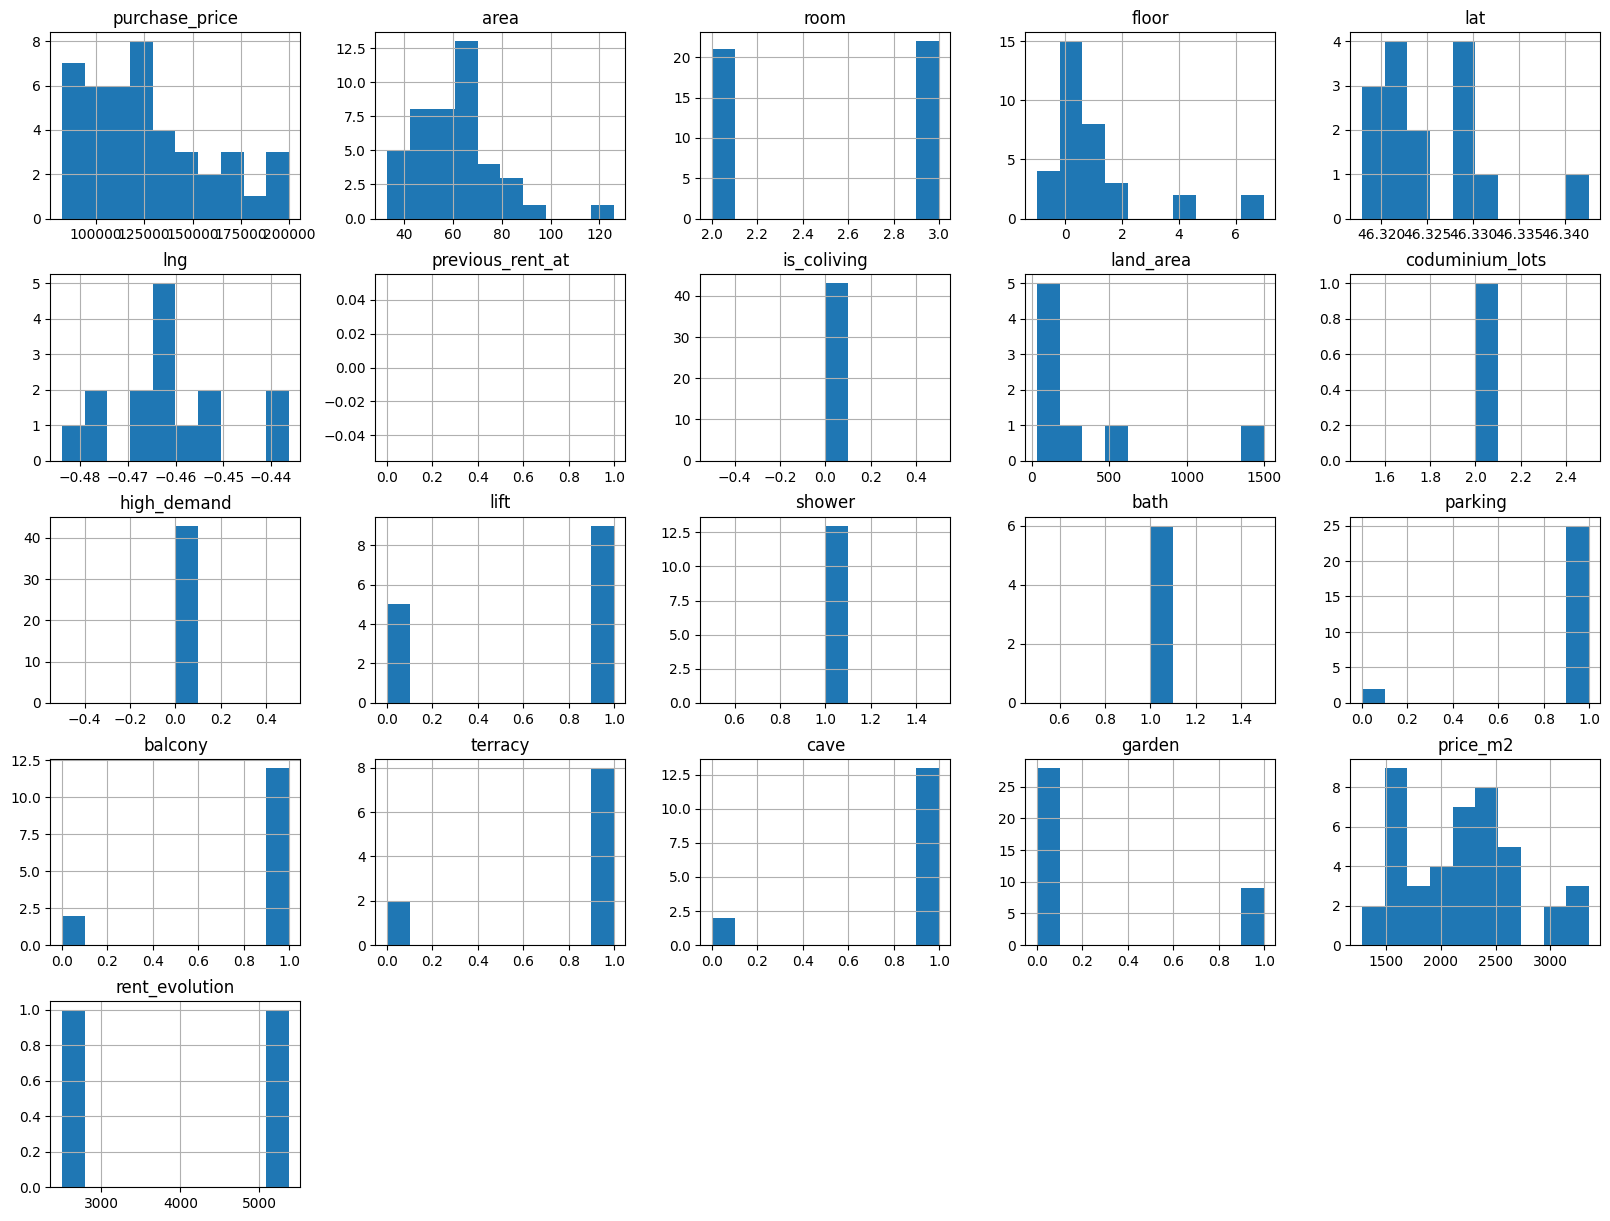

<Axes: xlabel='energy_dpe'>

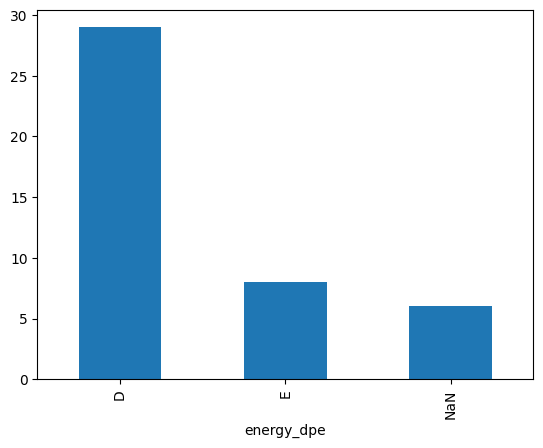

In [ ]:
print("df_filtered")
print("df_filtered")
print("df_filtered")
print("df_filtered")
print("df_filtered")
# Summary statistics for numerical columns
print(df_filtered.describe())

# Histograms for numerical columns
df_filtered.hist(figsize=(20, 15))
plt.show()

# Bar charts for categorical columns
# Replace 'categorical_column' with the actual column name
df_filtered['energy_dpe'].value_counts().plot(kind='bar')

print("df_biens")
print("df_biens")
print("df_biens")
print("df_biens")
print("df_biens")
# Summary statistics for numerical columns
print(df_biens.describe())

# Histograms for numerical columns
df_biens.hist(figsize=(20, 15))
plt.show()

# Bar charts for categorical columns
# Replace 'categorical_column' with the actual column name
df_biens['energy_dpe'].value_counts().plot(kind='bar')

print("df_prix_vente")
print("df_prix_vente")
print("df_prix_vente")
print("df_prix_vente")
print("df_prix_vente")
# Summary statistics for numerical columns
print(df_prix_vente.describe())

# Histograms for numerical columns
df_prix_vente.hist(figsize=(20, 15))
plt.show()

# Bar charts for categorical columns
# Replace 'categorical_column' with the actual column name
df_prix_vente['energy_dpe'].value_counts().plot(kind='bar')

In [ ]:
df_biens

,id,source,source_is_partner,owner_type,purchase_price,area,room,floor,type,city,postal_code,lat,lng,furnished,description,description_is_truncated,images,created_at,expired_at,sendDate,previous_rent_at,favorite,nb_spam,contacted,rentMinPerM2,clicked_at,alert_id,page,uuid,energy_dpe,energy_ges,favorite_id,quartier,is_coliving,should_reduce_info,source_is_subscribed,source_is_plato_supported,source_logo_fallback,quartier_name,spam_content_warning,reported_error,land_area,coduminium_lots,coduminium_charges,coduminium_pending_prejudice,high_demand,lift,shower,bath,parking,balcony,terracy,cave,garden,metro_stations,metro_lines,price_m2,rent_evolution,geo_coords,flat_type,id_bien,renovation_price,copro_price,aide_price,real_purchase_price,profitability
91,56051566,explorimmo,0,Agence,195120,126,2,0.0,Appartement,Niort,79000,NaN,NaN,0,"A VENDRE NIORT pour investisseur, 2 lots d'une superficie totale de 63m² chacun. Un appartement et un bureau, situés tous deux en RDC avec accès PMR idéalement situé en centre-ville de Niort. L'appartement est polyvalent et peut repasser …",True,"https://lh3.googleusercontent.com/IS4sp7Jl3L-9yvzap9g7IrcE1wXthohY43I6MQJIi5W88lC-EJd45ujQXF_04VhmQgseZZ23YTnCbSjmkFfEuIuc_9qcU-bO4lrzIA=rj-w940-h605-l80,https://lh3.googleusercontent.com/xgtCIFX1jVvbMcfJgcfSzU0Vt3KvvC9kuqkYcN-c9W_V4cVtznR292A_HOnBH9yGFg1yVdaMc5a7vavEacy40AzS6VtJEgpt0krNVw=rj-w940-h605-l80,https://lh3.googleusercontent.com/cZQjutWUra5MvS14H0IG6HAGhGkirYkcFayCavWJZyWG0uZ7EZMO6aTRq9QzdYLEpcOjZ3Iji_yDBy4S1QJINjAwPQaVaiBQx35z3cM=rj-w940-h605-l80,https://lh3.googleusercontent.com/IyktH45TLqA3KwZ35BONwYXpCXYjmNOz7-an_70YgdZIGOoYPzjo9ec8JCuLEAXdQGCmmJZAFuQNdjaOELpwkwvfH7KAeyTBp5Kw=rj-w940-h605-l80,https://lh3.googleusercontent.com/Y911Wyp8B2jjrnOVRKOIzJCpEQOatDYNWwM3fUpBRvV1S09k0a_OZpf8DZw1ec5YRRUn0AivC36szm52Su9Fkm62Bt21WbcnGw57VrU=rj-w940-h605-l80",2024-06-11T12:01:56.000Z,None,2024-06-11T12:01:56.000Z,NaN,False,0,NaN,None,1970-01-01T00:00:01.000Z,bb118b9b778d98fbf15c816802086edc,4,9ea13566-f9f4-446c-9ab2-510866d6afe9,NaN,NaN,None,None,0.0,False,False,False,https://ui-avatars.com/api/?background=d81094&color=000000&name=lefigaro.fr,None,False,False,NaN,NaN,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],{},1548.571429,NaN,<NA>,T2,grand_t2_achat,126000,2000,5000,318120,-57.31%


In [ ]:
# Assuming df_get_apparts_clean_new_features is your DataFrame
# Create a map centered around an average location
average_latitude = df_biens['lat'].mean() if pd.notna(df_biens['lat'].all()) else df_biens['lat'].median()
average_longitude = df_biens['lng'].mean() if pd.notna(df_biens['lat'].all()) else df_biens['lng'].median()

print(f"Average Latitude: {average_latitude}, Average Longitude: {average_longitude}")

# Create a map centered around the average location
if pd.isna(average_latitude)or pd.isna(average_longitude):
    pass
else:
    m = folium.Map(location=[average_latitude, average_longitude], zoom_start=12)

# Add points to the map
for idx, row in df_biens.iterrows():
    # Check if the 'latitude' and 'longitude' are not missing
    if pd.notna(row['lat']) and pd.notna(row['lng']):
        # Print the coordinates to verify they're being added #debug
        #print(f"Adding marker for coordinates: {row['lat']}, {row['lng']}")
        folium.Marker(location=[row['lat'], row['lng']]).add_to(m)
    else:
        pass
        # Print an error message if coordinates are missing
        #print(f"Missing coordinates at index {idx}") #debug

# Display the map
m

Average Latitude: nan, Average Longitude: nan


In [ ]:
# Calculate IQR for 'rent' as an example
Q1 = df_biens['purchase_price'].quantile(0.25)
Q3 = df_biens['purchase_price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
outliers = df_biens[(df_biens['purchase_price'] < lower_bound) | (df_biens['purchase_price'] > upper_bound)]
print(outliers)


Empty DataFrame
Columns: [id, source, source_is_partner, owner_type, purchase_price, area, room, floor, type, city, postal_code, lat, lng, furnished, description, description_is_truncated, images, created_at, expired_at, sendDate, previous_rent_at, favorite, nb_spam, contacted, rentMinPerM2, clicked_at, alert_id, page, uuid, energy_dpe, energy_ges, favorite_id, quartier, is_coliving, should_reduce_info, source_is_subscribed, source_is_plato_supported, source_logo_fallback, quartier_name, spam_content_warning, reported_error, land_area, coduminium_lots, coduminium_charges, coduminium_pending_prejudice, high_demand, lift, shower, bath, parking, balcony, terracy, cave, garden, metro_stations, metro_lines, price_m2, rent_evolution, geo_coords, flat_type, id_bien, renovation_price, copro_price, aide_price, real_purchase_price, profitability]
Index: []


---
price per m2 / quartier





In [ ]:
# Assuming 'df' is your pandas DataFrame
# Calculate the average 'price_m2' for each 'quartier_name'
avg_price_per_quartier = df_biens.groupby('quartier_name')['price_m2'].mean().sort_values()

# Create a new column for the row number
df_biens['row_number'] = df_biens.index

#Better display
df_biens['price_m2'] = df_biens['price_m2'].round(0)

# Create the scatter plot
fig = px.scatter(df_biens, x='quartier_name', y='price_m2',
                 color='quartier_name', # Color by quartier_name
                 hover_data=['row_number', 'source', 'price_m2', 'area', 'copro_price', 'renovation_price'], # Add more data to hover
                 title='Price per m² by Quartier Name')

# Update the layout for better readability
fig.update_layout(
    xaxis_title="Quartier Name",
    yaxis_title="Price per m²",
    legend_title="Quartier Name",
    template='plotly_white', # Clean white background
    xaxis={'categoryorder':'array', 'categoryarray':avg_price_per_quartier.index.tolist()} # Sort x-axis by avg price
)

# Show the figure
fig.show()


In [ ]:
# Assuming 'df' is your pandas DataFrame
# Calculate the average 'price_m2' for each 'quartier_name'
avg_price_per_quartier = df_biens.groupby('quartier_name')['price_m2'].mean().sort_values()

# Create the boxplot
fig = px.box(df_biens, x='quartier_name', y='price_m2',
             color='quartier_name',  # Color by postal code for distinction
             category_orders={'quartier_name': avg_price_per_quartier.index.tolist()}, # Sort x-axis by avg price
             title='Price per m² by quartier')

# Update the layout for better readability
fig.update_layout(
    xaxis_title="Quartier",
    yaxis_title="Price per m²",
    legend_title="Quartiers",
    template='plotly_white' # Clean white background
)

# Show the figure
fig.show()


In [ ]:
# Assuming 'df' is your pandas DataFrame
# Calculate the average 'price_m2' for each 'quartier_name'
avg_price_per_quartier = df_biens.groupby('postal_code')['price_m2'].mean().sort_values()

# Create the boxplot
fig = px.box(df_biens, x='postal_code', y='price_m2',
             color='postal_code',  # Color by postal code for distinction
             category_orders={'postal_code': avg_price_per_quartier.index.tolist()}, # Sort x-axis by avg price
             title='Price per m² by Postal Code')

# Update the layout for better readability
fig.update_layout(
    xaxis_title="Postal Code",
    yaxis_title="Price per m²",
    legend_title="Postal Code",
    template='plotly_white' # Clean white background
)

# Show the figure
fig.show()


---
Geographical heatmap to visualize the concentration of properties and their ‘price_m2’.

In [ ]:
# Assuming 'geo_coords' is a string column with values like "lat, long"
# Split 'geo_coords' into two separate columns 'latitude' and 'longitude'

# Convert the new 'latitude' and 'longitude' columns to numeric
df_biens['lat'] = pd.to_numeric(df_biens['lat'], errors='coerce')
df_biens['lng'] = pd.to_numeric(df_biens['lng'], errors='coerce')

# Now you can calculate the mean of the 'latitude' and 'longitude' columns
average_latitude = df_biens['lat'].mean()
average_longitude = df_biens['lng'].mean()

if pd.isna(average_latitude)or pd.isna(average_longitude):
    pass
else:
    # Create a map centered around the average location
    m = folium.Map(location=[average_latitude, average_longitude], zoom_start=12)

# Prepare the data for the heatmap
heatmap_data = [
    (lat, lon, price) for lat, lon, price in zip(
        df_biens['lat'],
        df_biens['lng'],
        df_biens['price_m2']
    ) if pd.notna(lat) and pd.notna(lon) and pd.notna(price)
]


# Create the heatmap
HeatMap(heatmap_data, min_opacity=0.5, max_opacity=0.8,
        radius=25, blur=15, max_zoom=1, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'yellow', 1: 'red'}).add_to(m)

# Display the map
m


In [ ]:
# Set option to display full content of the column
pd.set_option('display.max_colwidth', None)

# Now, when you filter on the 'images' column, it should display the full URLs
print(df_biens['images'])


91    https://lh3.googleusercontent.com/IS4sp7Jl3L-9yvzap9g7IrcE1wXthohY43I6MQJIi5W88lC-EJd45ujQXF_04VhmQgseZZ23YTnCbSjmkFfEuIuc_9qcU-bO4lrzIA=rj-w940-h605-l80,https://lh3.googleusercontent.com/xgtCIFX1jVvbMcfJgcfSzU0Vt3KvvC9kuqkYcN-c9W_V4cVtznR292A_HOnBH9yGFg1yVdaMc5a7vavEacy40AzS6VtJEgpt0krNVw=rj-w940-h605-l80,https://lh3.googleusercontent.com/cZQjutWUra5MvS14H0IG6HAGhGkirYkcFayCavWJZyWG0uZ7EZMO6aTRq9QzdYLEpcOjZ3Iji_yDBy4S1QJINjAwPQaVaiBQx35z3cM=rj-w940-h605-l80,https://lh3.googleusercontent.com/IyktH45TLqA3KwZ35BONwYXpCXYjmNOz7-an_70YgdZIGOoYPzjo9ec8JCuLEAXdQGCmmJZAFuQNdjaOELpwkwvfH7KAeyTBp5Kw=rj-w940-h605-l80,https://lh3.googleusercontent.com/Y911Wyp8B2jjrnOVRKOIzJCpEQOatDYNWwM3fUpBRvV1S09k0a_OZpf8DZw1ec5YRRUn0AivC36szm52Su9Fkm62Bt21WbcnGw57VrU=rj-w940-h605-l80
Name: images, dtype: object


####Affichage d'images des biens

In [ ]:
# Iterate over each row in the DataFrame
for image_list in df_biens['images']:
    # Now, 'image_list' should be a list of URLs
    # Iterate over each URL in the list
    for url in image_list:
        display(Image(url=url))


---
dpe/ges

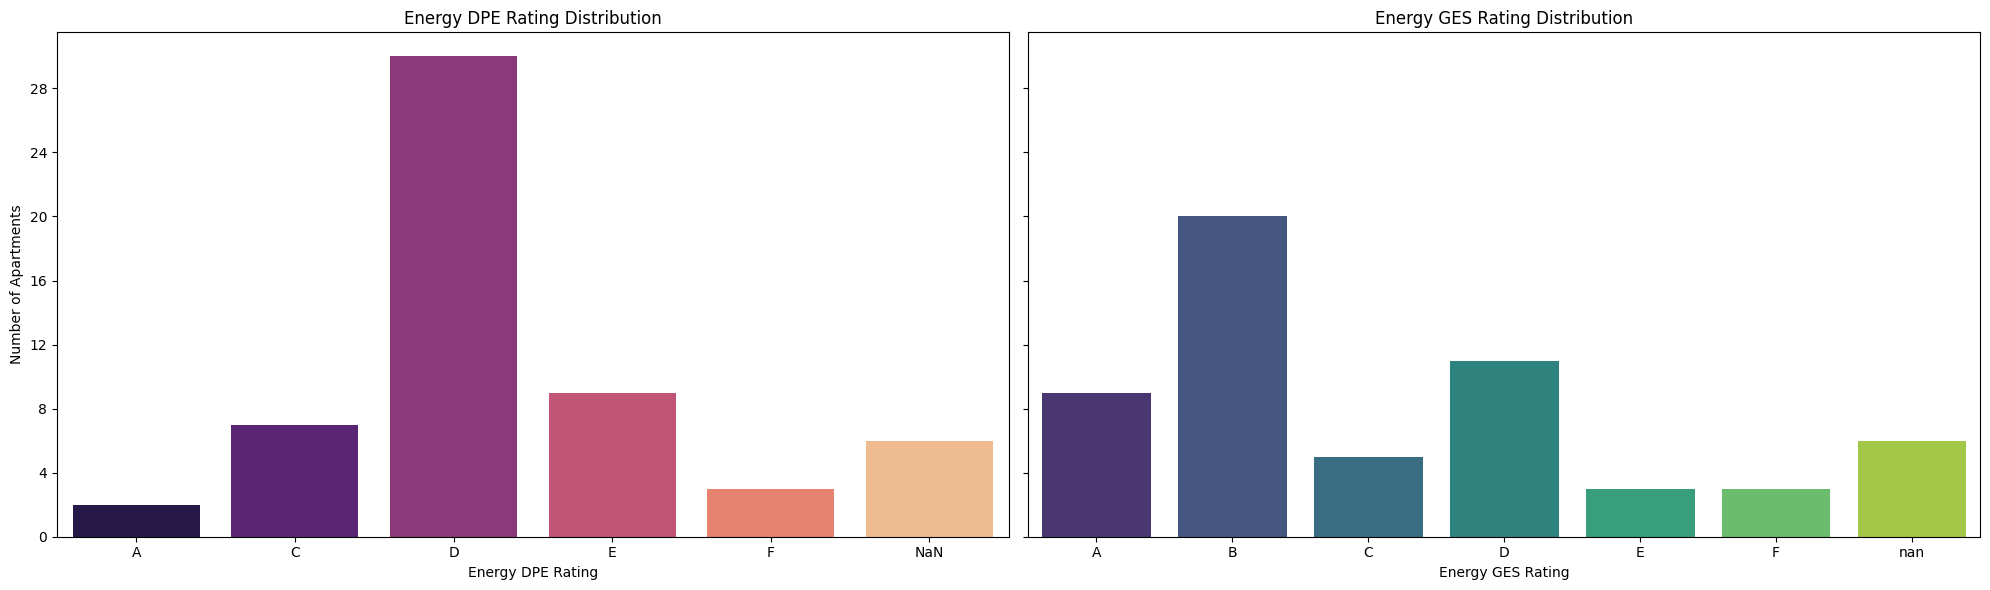

In [ ]:
# Convert 'energy_dpe' and 'energy_ges' to string, handling NaN values
df_filtered['energy_dpe'] = df_filtered['energy_dpe'].astype(str)
df_filtered['energy_ges'] = df_filtered['energy_ges'].astype(str)

# Sorting the 'energy_dpe' and 'energy_ges' columns alphabetically
df_filtered['energy_dpe'] = pd.Categorical(df_filtered['energy_dpe'], categories=sorted(df_filtered['energy_dpe'].unique()), ordered=True)
df_filtered['energy_ges'] = pd.Categorical(df_filtered['energy_ges'], categories=sorted(df_filtered['energy_ges'].unique()), ordered=True)

# Setting up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Plot for 'energy_dpe'
sns.countplot(ax=axes[0], x='energy_dpe', data=df_filtered, palette='magma')
axes[0].set_title('Energy DPE Rating Distribution')
axes[0].set_xlabel('Energy DPE Rating')
axes[0].set_ylabel('Number of Apartments')
axes[0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot for 'energy_ges'
sns.countplot(ax=axes[1], x='energy_ges', data=df_filtered, palette='viridis')
axes[1].set_title('Energy GES Rating Distribution')
axes[1].set_xlabel('Energy GES Rating')
axes[1].set_ylabel('')
axes[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Display the plots side by side
plt.tight_layout()
plt.show()


In [ ]:
df_biens

,id,source,source_is_partner,owner_type,purchase_price,area,room,floor,type,city,postal_code,lat,lng,furnished,description,description_is_truncated,images,created_at,expired_at,sendDate,previous_rent_at,favorite,nb_spam,contacted,rentMinPerM2,clicked_at,alert_id,page,uuid,energy_dpe,energy_ges,favorite_id,quartier,is_coliving,should_reduce_info,source_is_subscribed,source_is_plato_supported,source_logo_fallback,quartier_name,spam_content_warning,reported_error,land_area,coduminium_lots,coduminium_charges,coduminium_pending_prejudice,high_demand,lift,shower,bath,parking,balcony,terracy,cave,garden,metro_stations,metro_lines,price_m2,rent_evolution,geo_coords,flat_type,id_bien,renovation_price,copro_price,aide_price,real_purchase_price,profitability,row_number
91,56051566,explorimmo,0,Agence,195120,126,2,0.0,Appartement,Niort,79000,NaN,NaN,0,"A VENDRE NIORT pour investisseur, 2 lots d'une superficie totale de 63m² chacun. Un appartement et un bureau, situés tous deux en RDC avec accès PMR idéalement situé en centre-ville de Niort. L'appartement est polyvalent et peut repasser …",True,"https://lh3.googleusercontent.com/IS4sp7Jl3L-9yvzap9g7IrcE1wXthohY43I6MQJIi5W88lC-EJd45ujQXF_04VhmQgseZZ23YTnCbSjmkFfEuIuc_9qcU-bO4lrzIA=rj-w940-h605-l80,https://lh3.googleusercontent.com/xgtCIFX1jVvbMcfJgcfSzU0Vt3KvvC9kuqkYcN-c9W_V4cVtznR292A_HOnBH9yGFg1yVdaMc5a7vavEacy40AzS6VtJEgpt0krNVw=rj-w940-h605-l80,https://lh3.googleusercontent.com/cZQjutWUra5MvS14H0IG6HAGhGkirYkcFayCavWJZyWG0uZ7EZMO6aTRq9QzdYLEpcOjZ3Iji_yDBy4S1QJINjAwPQaVaiBQx35z3cM=rj-w940-h605-l80,https://lh3.googleusercontent.com/IyktH45TLqA3KwZ35BONwYXpCXYjmNOz7-an_70YgdZIGOoYPzjo9ec8JCuLEAXdQGCmmJZAFuQNdjaOELpwkwvfH7KAeyTBp5Kw=rj-w940-h605-l80,https://lh3.googleusercontent.com/Y911Wyp8B2jjrnOVRKOIzJCpEQOatDYNWwM3fUpBRvV1S09k0a_OZpf8DZw1ec5YRRUn0AivC36szm52Su9Fkm62Bt21WbcnGw57VrU=rj-w940-h605-l80",2024-06-11T12:01:56.000Z,None,2024-06-11T12:01:56.000Z,NaN,False,0,NaN,None,1970-01-01T00:00:01.000Z,bb118b9b778d98fbf15c816802086edc,4,9ea13566-f9f4-446c-9ab2-510866d6afe9,NaN,NaN,None,None,0.0,False,False,False,https://ui-avatars.com/api/?background=d81094&color=000000&name=lefigaro.fr,None,False,False,NaN,NaN,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],{},1549.0,NaN,<NA>,T2,grand_t2_achat,126000,2000,5000,318120,-57.31%,91


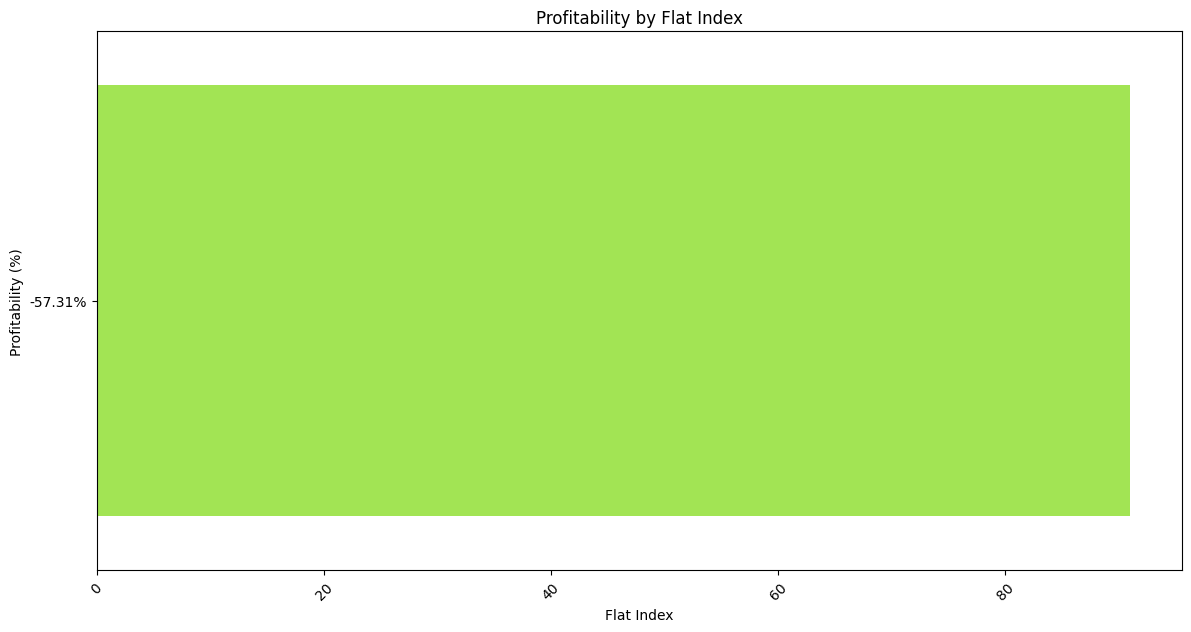

In [ ]:
# Assuming df_biens is your DataFrame and it's already sorted by profitability
top_10 = df_biens.head(10)

# Create a bar chart with 'turbo' palette and swapped axes
plt.figure(figsize=(14, 7))
sns.barplot(x=top_10.index, y='profitability', data=top_10, palette='turbo')
plt.title('Profitability by Flat Index')
plt.xlabel('Flat Index')
plt.ylabel('Profitability (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
# Create a map centered around the average coordinates of the top 10 flats
# Filter out rows where latitude or longitude is NaN
top_10 = top_10.dropna(subset=['lat', 'lng'])

# Create a map centered around the average location
map_center = [top_10['lat'].mean(), top_10['lng'].mean()]
if pd.isna(top_10['lat'].mean())or pd.isna(top_10['lng'].mean()):
    pass
else :
    map = folium.Map(location=map_center, zoom_start=12)

# Add markers for the top 10 most profitable flats
for _, row in top_10.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=f"{row['flat_type']}: {row['profitability']}",
        icon=folium.Icon(color='green')
    ).add_to(map)

# Display the map
map

map